## 译者前言
本篇讲稿从微观层面建立一个失业代理人的工作搜寻问题，并在之后的讲稿中不断补充细节。这个问题的一个典型的特点是：
- 具备离散的状态空间和选择空间。
- 通常是一个无限期问题（不过也有例外）
- 代理人最大化一个奖励函数（折现因子可有可无）
- 状态的转移涉及到马尔可夫过程

具备以上特点的问题我们通常会称为动态离散选择问题（discrete dynamic programs或discrete DPs）。对于经济学研究中的很多问题都可以基于这样的框架进行建模。“动态离散选择模型”之父John Rust在其著作《Numerical Dynamic Programming in Economics》对这类问题有着很详细且系统的研究(偏数理，并不适合入门)。事实上，离散选择过程（Discrete Decision Process，DDP）就是一类特殊的马尔可夫决策过程（Markov Decision Process，MDP）——其要求对每个状态空间，动作的个数是有限的。而我们在家庭储蓄消费模型中对于消费的选择，可以看作是一类连续选择过程（Continuous Decision Process，CDP）,其也可以看作是MDP的一类特例。

那么什么是马尔可夫决策过程？在经济学的研究中，这或许是一个陌生的名词，但对于数学以及人工智能领域却相当基础——尤其是强化学习（Reinforcement Learning）。感兴趣的同学可以去了解马尔可夫决策过程的具体定义，你可以简单理解为在马尔可夫过程中引入了决策，其可以影响到状态转移的概率。我们常见的各种经济学模型大都可以纳入这样的范畴，对奖励函数，状态和动作空间结合经济学知识进行具体化。Rust在1996年就写出了上面的那本书，而后续的经济学研究者（直至今日）也都是在具体化上面下功夫，使其更多地符合现实，更多地匹配数据。但MDP这一框架本身真的是那么完美吗？在强化学习领域中，MDP是一个相当Naǐve的入门级模型，因为其所有的状态是可见的（这也很符合economist的建模习惯，模型的机制必须是清楚可解释的）。但事实上呢？首先身为建模者的我们并不一定能对整个环境和代理人之间的交互有一个准确的认识，其次，代理人本身也对环境的认知也并不完全(partially，例：隐式马尔可夫链（POMDP）)，甚至有可能是错误的（需要后续与环境的交互进行纠正例：自适应性学习（adaptive learning））。

强化学习之父Richard Sutton在其教材《强化学习》中说到 "Reinforcement learning is learning what to do——how to map situations to actions——so as to maximize a numerical reward signal."即一个智能体如何在环境中采取一系列行为，从而获得最大的累积回报。这样的思想与经济学的最大化效用是不谋而合的。实际上，机器学习已经掀起了在经济学研究中的技术革命，正如有（无、半）监督学习被用于计量中的特征提取和因果推断，强化学习也应当在结构建模以及博弈论等涉及到智能体构建的经济问题中有着更为深远的应用。

以上是译者对于后面讲稿的一些感想，由于水平有限，如有纰漏，希望各位读者指出，如果您对我的相反感兴趣，也欢迎邮箱和我交流。
## 目录
- 概览
- McCall模型
- 计算最优策略：法1
- 比较静态分析（Comparative Statics）
- 计算最优策略：法2
- 练习
- 解答

## 概览
McCall搜寻模型帮助经济学家改变了对劳动力市场的思考方式。

为了纠正像“非自愿失业”这样模糊的概念，McCall建立了一个失业代理人的决策问题，其考虑了以下因素：
- 当前和未来可能的工资
- 不耐心程度
- 失业补偿金

为了解决这个决策问题，他使用了动态规划的工具。

这里，我们建立一个McCall的模型，并且采用相同的求解方法。

我们将会看到，McCall模型不仅本身很有趣，还是学习动态规划的一个极好的工具。

让我们从一些import开始：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import jit, float64
from numba.experimental import jitclass
import quantecon as qe
from quantecon.distributions import BetaBinomial

## McCall模型
一个失业的代理人在每期会收到一个工资为$w_t$的offer。

工资大小是一个有关一些潜在状态变量的一个非负的函数：
$$
w_t = w(s_t) \quad \text{where } \; s_t \in \mathbb{S}
$$

这里我们认为状态变量是一些影响工资的潜在的的，未知的随机因素。

（引入外生的随机状态过程是经济学家向模型中引入随机性的标准做法之一。）

在本篇讲座当中，我们假设以下的一个简单的环境：
- $\{s)t\}$满足IID分布，其中$q(s)$是在每期观察到$s \in \mathbb{S}$状态的概率。
- 代理人在t期开始时观察到$s_t$，并因此知道$w_t = w(s_t)$。
- 集合$\mathbb{S}$是有限的。
（在之后的讲座中，我们将会放松这些假设）

在$t$期,我们的代理人有两种选择：
1. 接受这个offer并且以工资$w_t$永远的工作下去
2. 拒绝这个offer，接受失业补偿金$c$，并且在下一期重新考虑。

代理人将无限期的存辉，并且意图最大化总收益的折现值：
$$
\mathbb{E}\sum_{t = 0}^{\infty} = \beta^ty_t
$$
常数$\beta \in (0,1)$，被称作折现因子（discount factor）

$\beta$越小，代理人在未来获得的效用的折现就会越少。

变量$y_t$是收入，其等于：
- 当他被雇佣时，是工资$w_t$
- 当他仍然处于失业时，是就业补偿金$c$

假设代理人知道$\{s_t\}$是满足IID，且具有相同的分布q；并且可以利用这点计算期望。

### 权衡取舍（a Trade-Off）
工人面临一项权衡取舍：
- 花费太长时间去等待一项好的offer代价较大，因为未来的效用需要进行折现。
- 太早地接受offer同样需要付出代价，因为未来可能会有更好的offer。

在面临权衡问题上进行最优决策，我们就要用到动态规划。

动态规划可以认为是由两步组成：
1. 首先为在“状态”进行赋值，
2. 然后根据给定的值推断出最佳的决策。

我们将按顺序进行这些步骤。
### 值函数
为了在现在和未来收益的权衡取舍下做出最优选择，我们需要去思考以下两个问题：
1. 我们在不同选择下获得的当前回报
2. 这些选择所导致的下一期的状态变量（在这个例子中，就是失业和就业两种状态）

为了权衡决策模型的这两个问题，我们需要对状态进行赋值。

因此，令$v^*(s)$等于一个失业工人在$s \in \mathbb{S}$时的终身总价值。

特别地，代理人手上有一个工资为$w(s)$的offer。

更加准确的说，$v^*(s)$表示当代理人在当前和未来所有时间点都做出最优决策时的目标效用函数（$\mathbb {E}\sum_{t = 0}^{\infty}\beta^tu(y_t)$）的值。

当然，$v^*(s)$并不是那么容易去计算，因为你并不知道哪些决策是最优的。

但是我们将$v^*$视作每个可能的状态变量$s$下手里的offer可以获得的最大化的终身价值。

一个重要的发现是这个函数$v^*$必须满足如下的递归：
$$
v^*(s)
= \max \left\{
        \frac{w(s)}{1 - \beta}, \, c + \beta
        \sum_{s' \in \mathbb{S}} v^*(s') q (s')
    \right\} 
$$

上式对于对于任意的$s \in \mathbb{S}$都满足。

这个重要的等式便是**贝尔曼方程（Bellman Equation）** 的一个版本，这在动态经济学和其他规划问题的领域中无处不在。

这个式子背后的直觉是：
- 最大化式子中的第一个部分代表接受当前offer的终身效益，因为：
$$
\frac{w(s)}{1 - \beta} = w(s) + \beta w(s) + \beta^2 w(s) + \cdots
$$
- 二第二个部分则是**延拓值（continuation value）** ，其是拒绝掉这个offer并在接下来的时期都做出最佳决策所得到的终身效益。

给定当前的状态变量$s$，如果我们做出了最优决策我们就可以计算出从今天开始的的最大化终身效用。

### 最优策略
假设我们现在可以计算出未知的函数$v^*$。

一旦我们有了这个函数形式，我们就可以做出最优决策（即在接受和拒绝offer之间做出正确的选择）。

所有我们需要去做的就是选择使得22.1的右式最大化的决策。

最优的决策被认为是一种策略（policy），其被认为是从状态变量到决策的映射。

给定任意的$s$，我们可以通过选择22.1等式右边的最大值来读出我们的最佳决策。

因此，我们有一个从$\mathbb{R}$到$\{0,1\}$的映射，其中1表示接受，0表示拒绝。

我们可以将策略函数写成下面的形式：
$$
\sigma(s) := \mathbf{1}
    \left\{
        \frac{w(s)}{1 - \beta} \geq c + \beta \sum_{s' \in \mathbb S}
        v^*(s') q (s')
    \right\}
$$

其中$ \mathbf{1}\{ P \} = 1 $是指示函数（indicator function），表示如果$P$成立，则等于1，否则等于0。

我们也可以写作：
$$
\sigma(s) := \mathbf{1} \{ w(s) \geq \bar w \}
$$
其中：
$$
\bar w := (1 - \beta) \left\{ c + \beta \sum_{s'} v^*(s') q (s') \right\} 
$$

这里$\bar w$（称作保留价格（reservation wage））是一个与$\beta,c$和工资的概率分布相关的常数。

代理人应该接受这个offer当且仅当现在offer的工资超过保留价格。

因此，如果我们能计算出值函数，我们也能计算出保留价格。

## 计算最优策略：法1
为了将上述的思想付诸于行动，我们需要计算每个可能的状态$s \in \mathbb{S}$的值函数。

我们假设$\mathbb{S} = \{1,\cdots,n\}$。

则我们使用$v^* = (v^*(i))^n_{i=1}$来表示一系列值函数。

由22.1可知，这个向量满足如下的一个非线性系统：
$$
v^*(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v^*(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n 
$$

### 算法
为了计算这组向量，我们使用逐次逼近法（successive approximations）：

step 1：任意假设一个$v \in \mathbb{R}^n$的初值。

step 2：利用下式计算出新的向量$v' \in \mathbb{R}^n$:
$$
v'(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n 
$$

step 3：计算一个关于$v$和$v'$之间的偏差的度量，例如$\max_i |v(i)-v'(i)|$

step 4：如果这个偏差大于某个固定的临界值，令$v = v'$并且回到step 2，如果不是，则继续下一步

step 5：输出$v$

当临界值取得足够小时，输出的函数$v$就会很近似于值函数$v^*$。

下面的理论解释了这一点。

### 不动点定理
上述这个想法背后的数学原理是什么呢？

首先，我们定义了一个从$\mathbb{R^n}$到其自身的一个映射T：
$$
(Tv)(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n 
$$

逐次逼近法序列$\{v_k\}$中的元素$v_k$相当于$T^kv$
- 这是从初值$v$开始，将T进行迭代$k$次后得到的。

可以证明$\mathbb{R}^n$上的$T$映射满足**巴拿赫不动点定理（Banach fixed point theorem）,也叫压缩映射定理** 

一个推论就是$T$在$\mathbb{R}^n$上有一个唯一的不动点。
- 即一个唯一的向量$\bar v$满足$T\bar v = \bar v$

第二个关于巴拿赫不动点定理的推论就是无论初值$v$的取值，$\{T^kv\}$一定会收敛到不动点$v^*$。

### 实现
我们默认分布$q$满足$\beta$-二项式分布：

In [2]:
n, a, b = 50, 200, 100                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # default choice of q

我们默认工资的集合是：

In [3]:
w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)

下图表示了不同工资收入及其概率：

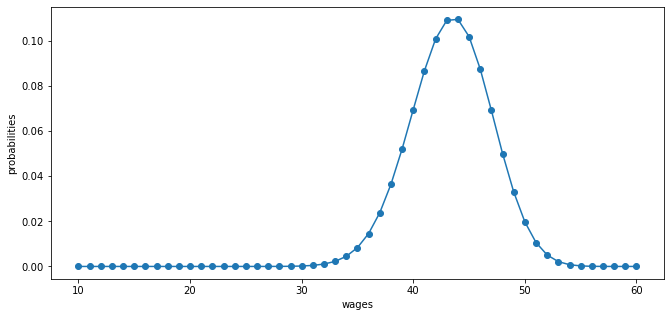

In [4]:
fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

我们将使用Numba去加速我们的代码：

首先我们需要帮助Numba识别变量类型：

In [5]:
mccall_data = [
    ('c', float64),      # unemployment compensation
    ('β', float64),      # discount factor
    ('w', float64[:]),   # array of wage values, w[i] = wage at state i
    ('q', float64[:])    # array of probabilities
]

这是一个存储数据并且在给定当前状态和任意可行的动作后计算状态-动作序列的一个类，即贝尔曼方程22.4等式右边中最大化符号内部的值。

默认参数的值嵌入在类的定义当中。

In [6]:
@jitclass(mccall_data)
class McCallModel:

    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):

        self.c, self.β = c, β
        self.w, self.q = w_default, q_default

    def state_action_values(self, i, v):
        """
        The values of state-action pairs.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # Evaluate value for each state-action pair
        # Consider action = accept or reject the current offer
        accept = w[i] / (1 - β)
        reject = c + β * np.sum(v * q)

        return np.array([accept, reject])

在这些设定下，我们试着画出序列$\{T^kv\}$的前几个近似的值函数。

我们初始对$v$的猜测是$v(i) = w(i)/(1-\beta)$，这是对任意的offer工资都会选择接受的值。

下面是实现他的函数：

In [7]:
def plot_value_function_seq(mcm, ax, num_plots=6):
    """
    Plot a sequence of value functions.

        * mcm is an instance of McCallModel
        * ax is an axes object that implements a plot method.

    """

    n = len(mcm.w)
    v = mcm.w / (1 - mcm.β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        # Update guess
        for i in range(n):
            v_next[i] = np.max(mcm.state_action_values(i, v))
        v[:] = v_next  # copy contents into v

    ax.legend(loc='lower right')

现在我们创造一个McCallModel的实例，并且调用这个函数：

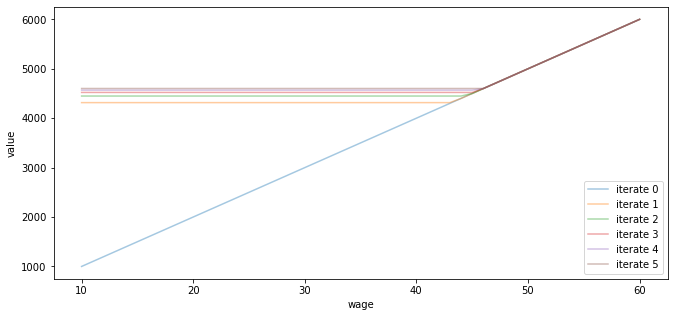

In [8]:
mcm = McCallModel()

fig, ax = plt.subplots()
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mcm, ax)
plt.show()

从上图中可以看到收敛正在发生：逐次迭代的结果在不断的接近。

我们采用一个更严格的迭代来计算极限，他会一直持续迭代直至两次迭代之间的测量误差小于临界值。

我们将使用Numba的JIT编译来加速循环。

In [9]:
@jit(nopython=True)
def compute_reservation_wage(mcm,
                             max_iter=500,
                             tol=1e-6):

    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute the value function == #

    n = len(w)
    v = w / (1 - β)          # initial guess
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        for i in range(n):
            v_next[i] = np.max(mcm.state_action_values(i, v))

        error = np.max(np.abs(v_next - v))
        i += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * q))

下一行代码计算了在当前设定下的保留价格。

In [10]:
compute_reservation_wage(mcm)

47.316499710024964

## 比较静态分析（Comparative Statics）
我们已经知道了如何去计算保留价格，现在让我们看看他是如何随参数变化而变化。

特别地，我们看看当$\beta$和$c$变化时会发生什么：

In [11]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcm = McCallModel(c=c, β=β)
        R[i, j] = compute_reservation_wage(mcm)

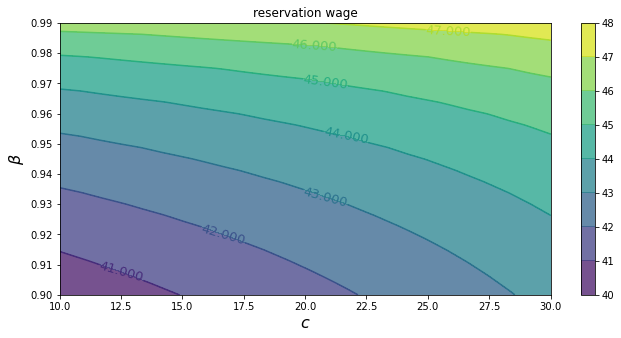

In [15]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

和期望的一样，保留价格随着你的耐心程度和失业补偿金的增加而增加。

## 计算最优策略：法2
前面叙述的动态规划方法时非常标准和具有普适性的。

对于这个特殊的为题，也有一个非常简单的方法，他可以避免对值函数进行计算。

令$h$表示延拓值：
$$
h
= c + \beta
    \sum_{s'} v^*(s') q (s')
\quad 
$$

则贝尔曼方程可以写作：
$$
v^*(s')
= \max \left\{ \frac{w(s')}{1 - \beta}, \, h \right\}
$$

带入到22.6式中可以得到：
$$
h
= c + \beta
    \sum_{s' \in \mathbb S}
    \max \left\{
        \frac{w(s')}{1 - \beta}, h
    \right\}  q (s')
\quad 
$$

这是一个非线性方程，我们可以求出$h$。

和之前一样，我们将采用逐次逼近法。
step 1：任意假设一个$h$的初值。

step 2：利用下式计算出新的向量$h'$:
$$
h'
= c + \beta
    \sum_{s' \in \mathbb S}
    \max \left\{
        \frac{w(s')}{1 - \beta}, h
    \right\}  q (s')
$$

step 3：计算偏差$|h-h'|$

step 4：如果这个偏差大于某个固定的临界值，令$h = h'$并且回到step 2，如果不是，则输出$h$。

同样的，我们可以使用压缩映射定理证明这样的过程总是收敛的。

但与之前的方法最大的不同在于我们只需要对一个单一的值进行迭代而不是一组$n$维的向量。

这是他的实现过程：


In [16]:
@jit(nopython=True)
def compute_reservation_wage_two(mcm,
                                 max_iter=500,
                                 tol=1e-5):

    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute h == #

    h = np.sum(w * q) / (1 - β)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        s = np.maximum(w / (1 - β), h)
        h_next = c + β * np.sum(s * q)

        error = np.abs(h_next - h)
        i += 1

        h = h_next

    # == Now compute the reservation wage == #

    return (1 - β) * h

你可以使用这个方法去完成下面的练习：

## 练习
### 练习1
当$\beta = 0.99$,$c$取值如下时，计算失业的平均持续时间：

In [17]:
c_vals = np.linspace(10, 40, 25)

也就是说，将代理人初始设置为失业人员，在给定参数的情况下计算他们的保留价格，然后模拟他们接受offer所花费的时间。

你需要进行大量多次的模拟并取平均值。

画出平均失业持续时间和$c$的关系。

### 练习2 
这个练习的目的时说明如何将离散的工资分布转换成连续的。

这是一个很重要的问题，因为很多实用的分布都是连续的。（比如密度）

幸运的时，这个理论只需要在我们的简单模型上进行一些微小的改动。

回想一下，22.6式子中的$h$表示在当期不接受offer并且在之后所有时期都做出最佳选择的效益。

为了将其转换成连续型的分布，我们只需要将22，6式变成如下形式：
$$
h
= c + \beta
    \int v^*(s') q (s') ds'.
\quad 
$$

那么式22.7变成：
$$
h
= c + \beta
    \int
    \max \left\{
        \frac{w(s')}{1 - \beta}, h
    \right\}  q (s') d s'
\quad 
$$

我们要通过迭代法来求解这一非线性方程，并从中计算出保留工资。

试着将这道题解决，令：
- 状态变量$\{s_t\}$是满足正态分布的IID过程
- 工资函数的形式是：$w(s) = \exp{(\mu+ \sigma s)}$

你将要实现一个McCall类的一个全新版本——其工资满足对数正态分布。

你可以通过从分布中取出大量的工资进行平均值计算，通过蒙特卡洛模拟法进行积分。

对于参数设置，我们取$c = 25,\beta  = 0.99,\sigma = 0.5,\mu = 2.5$。

一旦你的代码成功了，试着探究保留工资如何随着$c$和$\beta$的变化而变化。

## 解答
### 练习1

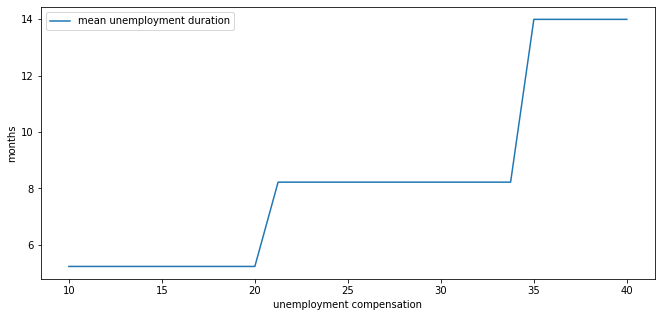

In [18]:
cdf = np.cumsum(q_default)

@jit(nopython=True)
def compute_stopping_time(w_bar, seed=1234):

    np.random.seed(seed)
    t = 1
    while True:
        # Generate a wage draw
        w = w_default[qe.random.draw(cdf)]
        # Stop when the draw is above the reservation wage
        if w >= w_bar:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time

@jit(nopython=True)
def compute_mean_stopping_time(w_bar, num_reps=100000):
    obs = np.empty(num_reps)
    for i in range(num_reps):
        obs[i] = compute_stopping_time(w_bar, seed=i)
    return obs.mean()

c_vals = np.linspace(10, 40, 25)
stop_times = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c)
    w_bar = compute_reservation_wage_two(mcm)
    stop_times[i] = compute_mean_stopping_time(w_bar)

fig, ax = plt.subplots()

ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()

### 练习2

In [19]:
mccall_data_continuous = [
    ('c', float64),          # unemployment compensation
    ('β', float64),          # discount factor
    ('σ', float64),          # scale parameter in lognormal distribution
    ('μ', float64),          # location parameter in lognormal distribution
    ('w_draws', float64[:])  # draws of wages for Monte Carlo
]

@jitclass(mccall_data_continuous)
class McCallModelContinuous:

    def __init__(self, c=25, β=0.99, σ=0.5, μ=2.5, mc_size=1000):

        self.c, self.β, self.σ, self.μ = c, β, σ, μ

        # Draw and store shocks
        np.random.seed(1234)
        s = np.random.randn(mc_size)
        self.w_draws = np.exp(μ+ σ * s)


@jit(nopython=True)
def compute_reservation_wage_continuous(mcmc, max_iter=500, tol=1e-5):

    c, β, σ, μ, w_draws = mcmc.c, mcmc.β, mcmc.σ, mcmc.μ, mcmc.w_draws

    h = np.mean(w_draws) / (1 - β)  # initial guess
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        integral = np.mean(np.maximum(w_draws / (1 - β), h))
        h_next = c + β * integral

        error = np.abs(h_next - h)
        i += 1

        h = h_next

    # == Now compute the reservation wage == #

    return (1 - β) * h

In [20]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcmc = McCallModelContinuous(c=c, β=β)
        R[i, j] = compute_reservation_wage_continuous(mcmc)

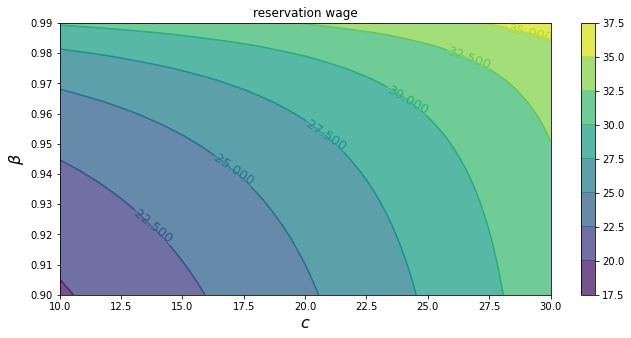

In [21]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()